Fetching Data (2020-01-01 to Present)...
Running Backtest Simulation...
Generating Fact Sheet...


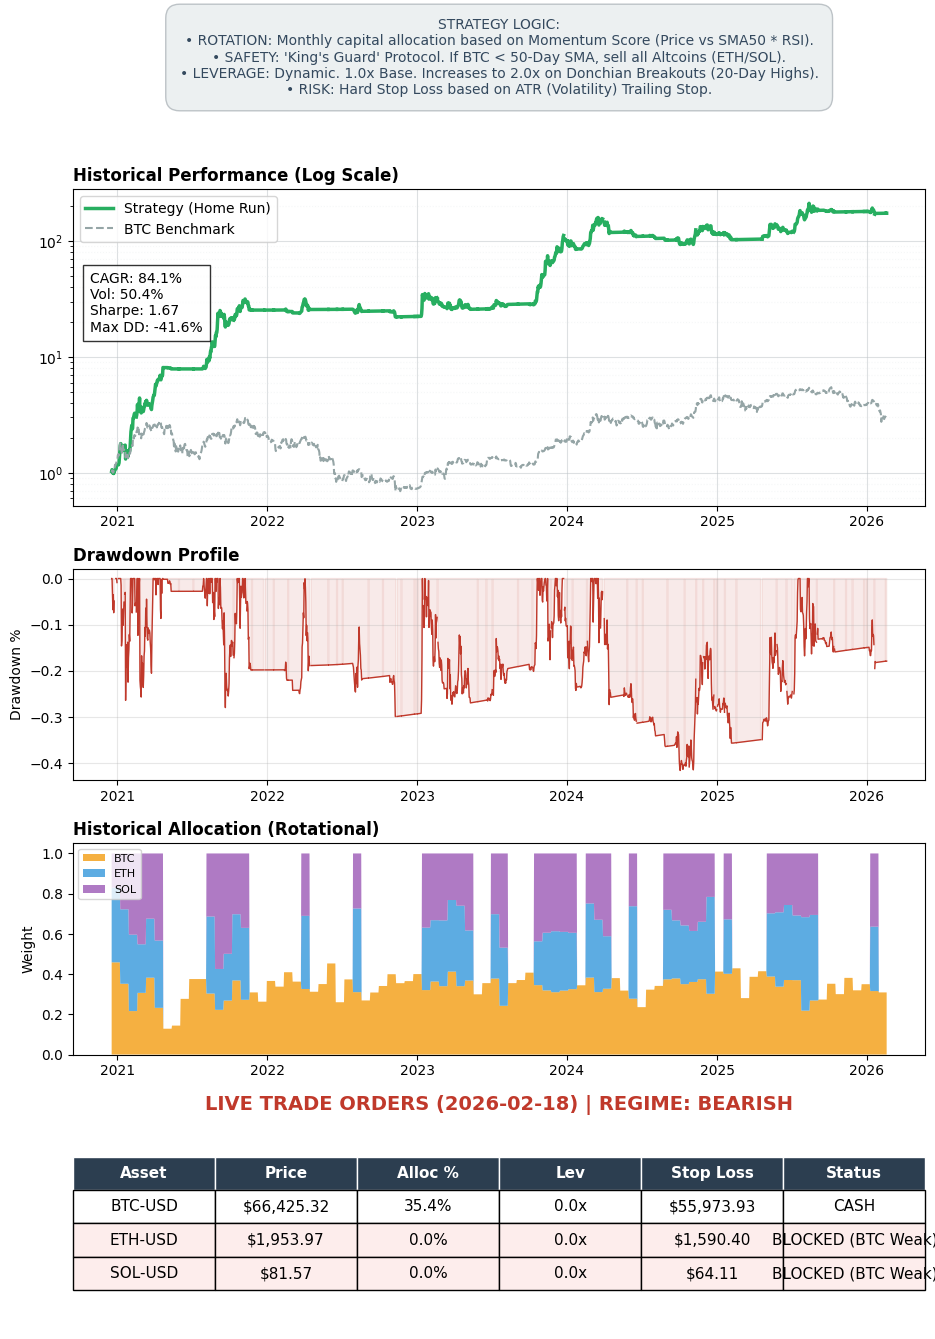

In [3]:
# @title Loras Strategy Fact Sheet (Clean White Edition)
# @markdown **Instructions:**
# @markdown 1. Run this block.
# @markdown 2. Wait for the data fetch (approx 5-10s).
# @markdown 3. The script will output a high-resolution, white-background Fact Sheet.
# @markdown 4. It includes Methodology, Backtest Evidence, and the **Live Trade Desk**.

import sys
import subprocess
import warnings

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import yfinance as yf
    import pandas_datareader as pdr
except ImportError:
    print("Installing required packages...")
    install('yfinance')
    install('pandas_datareader')
    import yfinance as yf
    import pandas_datareader as pdr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
# Set clean white style
plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'

# ==========================================
# 1. GLOBAL CONFIGURATION
# ==========================================
class Config:
    TICKERS = ['BTC-USD', 'ETH-USD', 'SOL-USD']
    BENCHMARK = 'BTC-USD'
    RISK_FREE_SYMBOL = 'DGS3MO'

    # Dates
    START_DATE = '2020-01-01'
    END_DATE = datetime.today().strftime('%Y-%m-%d')

    # Settings
    MAX_LEVERAGE = 2.0
    ATR_PERIOD = 14
    ATR_MULTIPLIER = 2.5
    TRAIN_WINDOW_YEARS = 1.0
    TEST_WINDOW_MONTHS = 1 # Rebalance frequency

# ==========================================
# 2. DATA & CALCULATIONS
# ==========================================
def get_data_and_signals():
    print(f"Fetching Data ({Config.START_DATE} to Present)...")
    try:
        # Fetch Data
        raw = yf.download(Config.TICKERS, start=Config.START_DATE, end=Config.END_DATE, progress=False, auto_adjust=False)

        # Handle yfinance multi-index if present
        if isinstance(raw.columns, pd.MultiIndex):
            # Try to flatten or select specific levels
            try:
                prices = raw['Adj Close']
                highs = raw['High']
                lows = raw['Low']
            except KeyError:
                prices = raw['Close']
                highs = raw['High']
                lows = raw['Low']
        else:
            prices = raw['Adj Close'] if 'Adj Close' in raw.columns else raw['Close']
            highs = raw['High'] if 'High' in raw.columns else prices
            lows = raw['Low'] if 'Low' in raw.columns else prices

        # Clean NaNs
        prices = prices.dropna()
        highs = highs.dropna()
        lows = lows.dropna()

    except Exception as e:
        print(f"Data Error: {e}")
        return None, None, None, None, None

    # Risk Free Rate
    try:
        rf = pdr.get_data_fred(Config.RISK_FREE_SYMBOL, start=Config.START_DATE, end=Config.END_DATE)
        rf = rf.resample('D').ffill() / 100 / 252
        rf.columns = ['RiskFree']
    except:
        rf = pd.DataFrame({'RiskFree': 0.04/252}, index=prices.index)

    # Align Indices
    common = prices.index.intersection(rf.index)
    prices = prices.loc[common]
    highs = highs.loc[common]
    lows = lows.loc[common]
    rf = rf.loc[common]
    returns = prices.pct_change().dropna()

    return prices, highs, lows, rf, returns

def calc_indicators(prices, highs, lows):
    signals = pd.DataFrame(index=prices.index)

    # 1. Trend (Fast/Slow EMA)
    fast_ma = prices.ewm(span=10).mean()
    slow_ma = prices.ewm(span=40).mean()
    signals['Trend'] = np.where(fast_ma > slow_ma, 1.0, 0.0)

    # 2. Breakout (20 Day High)
    # Note: Shift(1) is strictly for backtesting to avoid lookahead.
    # For Live Desk, we check if Current Price > Yesterday's High_20
    prev_high_20 = prices.shift(1).rolling(20).max()
    signals['Breakout'] = np.where(prices > prev_high_20, 1.0, 0.0)

    # 3. Momentum Score (For Allocation)
    sma50 = prices.rolling(50).mean()
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean().replace(0, 0.001)
    rsi = 100 - (100 / (1 + gain/loss))
    signals['Mom_Score'] = (prices / sma50) * (rsi / 50)

    # 4. Stop Loss (ATR)
    tr = pd.concat([highs-lows, (highs-prices.shift(1)).abs(), (lows-prices.shift(1)).abs()], axis=1).max(axis=1)
    atr = tr.rolling(Config.ATR_PERIOD).mean()
    signals['Stop_Price'] = prices - (atr * Config.ATR_MULTIPLIER)

    return signals

# ==========================================
# 3. BACKTEST SIMULATION
# ==========================================
def run_backtest(prices, highs, lows, returns, rf):
    print("Running Backtest Simulation...")
    dates = prices.index
    start_idx = int(Config.TRAIN_WINDOW_YEARS * 252)
    step_idx = 21 # Monthly Rebalance

    oos_rets = []
    w_hist = []

    # Pre-calc Indicators
    sig_map = {t: calc_indicators(prices[t], highs[t], lows[t]) for t in Config.TICKERS}
    btc_sma = prices['BTC-USD'].rolling(50).mean()

    for i in range(start_idx, len(dates), step_idx):
        train_end = dates[i]
        test_end_idx = min(i + step_idx, len(dates))
        if i >= test_end_idx: break
        test_range = dates[i:test_end_idx]

        # --- ALLOCATION LOGIC ---
        scores = {}
        for t in Config.TICKERS:
            # Use 'train_end' data (yesterday relative to rebalance)
            try:
                s = sig_map[t].loc[:train_end].iloc[-1]['Mom_Score']
                scores[t] = max(0, s)
            except:
                scores[t] = 0

        total = sum(scores.values())
        weights = {t: (scores[t]/total if total > 0 else 0) for t in Config.TICKERS}

        # BTC Guard
        if prices['BTC-USD'].loc[train_end] < btc_sma.loc[train_end]:
            weights['ETH-USD'] = 0.0
            weights['SOL-USD'] = 0.0
            # Note: We do NOT re-allocate to BTC. Weight goes to Cash.

        w_hist.append({'Date': dates[i], **weights})

        # --- EXECUTION LOGIC ---
        for day in test_range:
            day_ret = 0.0
            total_exp = 0.0
            for t in Config.TICKERS:
                # Use signal from 'yesterday' to trade 'today'
                sig = sig_map[t].loc[:day].iloc[-2]

                # Leverage Rules
                lev = 0.0
                if sig['Trend'] > 0:
                    lev = Config.MAX_LEVERAGE if sig['Breakout'] > 0 else 1.0

                pos = weights[t] * lev
                total_exp += pos

                # Returns - Cost (Simplified)
                r = returns.loc[day, t]
                cost = abs(pos) * 0.0001 # Small daily drag proxy
                day_ret += (pos * r) - cost

            # Cash Yield
            day_ret += (1 - total_exp) * rf['RiskFree'].loc[day]
            oos_rets.append(day_ret)

    return pd.Series(oos_rets, index=dates[-len(oos_rets):]), pd.DataFrame(w_hist).set_index('Date')

# ==========================================
# 4. FACT SHEET GENERATOR (VISUALS)
# ==========================================
def generate_fact_sheet(prices, highs, lows, results, weights, benchmark_rets):
    print("Generating Fact Sheet...")

    # Layout Setup
    fig = plt.figure(figsize=(11, 17)) # A3/Tabloid Ratio
    fig.patch.set_facecolor('white')
    gs = gridspec.GridSpec(5, 1, height_ratios=[0.4, 1.2, 0.8, 0.8, 0.8], hspace=0.3)

    # --- 1. HEADER & METHODOLOGY ---
    ax_head = fig.add_subplot(gs[0])
    ax_head.axis('off')

    title = "LORAS 'HOME RUN' STRATEGY"
    subtitle = "QUANTITATIVE CRYPTO MOMENTUM & ROTATION"

    methodology = (
        "STRATEGY LOGIC:\n"
        "• ROTATION: Monthly capital allocation based on Momentum Score (Price vs SMA50 * RSI).\n"
        "• SAFETY: 'King's Guard' Protocol. If BTC < 50-Day SMA, sell all Altcoins (ETH/SOL).\n"
        "• LEVERAGE: Dynamic. 1.0x Base. Increases to 2.0x on Donchian Breakouts (20-Day Highs).\n"
        "• RISK: Hard Stop Loss based on ATR (Volatility) Trailing Stop."
    )

    ax_head.text(0.5, 0.85, title, ha='center', fontsize=24, weight='bold', color='#2c3e50')
    ax_head.text(0.5, 0.70, subtitle, ha='center', fontsize=12, weight='bold', color='#7f8c8d')
    ax_head.text(0.5, 0.30, methodology, ha='center', fontsize=10, color='#34495e',
                 bbox=dict(boxstyle="round,pad=1", fc="#ecf0f1", ec="#bdc3c7"))

    # --- 2. CUMULATIVE PERFORMANCE ---
    ax_perf = fig.add_subplot(gs[1])
    cum_strat = (1 + results).cumprod()
    cum_bench = (1 + benchmark_rets.loc[results.index]).cumprod()

    ax_perf.plot(cum_strat, color='#27ae60', linewidth=2.5, label='Strategy (Home Run)')
    ax_perf.plot(cum_bench, color='#95a5a6', linewidth=1.5, linestyle='--', label='BTC Benchmark')
    ax_perf.set_yscale('log')
    ax_perf.set_title("Historical Performance (Log Scale)", fontsize=12, weight='bold', loc='left')
    ax_perf.grid(True, which='major', color='#bdc3c7', linestyle='-', alpha=0.5)
    ax_perf.grid(True, which='minor', color='#ecf0f1', linestyle=':', alpha=0.5)
    ax_perf.legend(loc='upper left', frameon=True)

    # KPI Box
    cagr = results.mean() * 252
    vol = results.std() * np.sqrt(252)
    sharpe = cagr / vol
    dd = cum_strat / cum_strat.cummax() - 1
    kpis = f"CAGR: {cagr:.1%}\nVol: {vol:.1%}\nSharpe: {sharpe:.2f}\nMax DD: {dd.min():.1%}"
    ax_perf.text(0.02, 0.55, kpis, transform=ax_perf.transAxes, fontsize=10,
                 bbox=dict(boxstyle="square,pad=0.5", fc="white", ec="black", alpha=0.8))

    # --- 3. DRAWDOWN ---
    ax_dd = fig.add_subplot(gs[2])
    ax_dd.plot(dd, color='#c0392b', linewidth=1)
    ax_dd.fill_between(dd.index, dd, 0, color='#c0392b', alpha=0.1)
    ax_dd.set_title("Drawdown Profile", fontsize=12, weight='bold', loc='left')
    ax_dd.grid(True, alpha=0.3)
    ax_dd.set_ylabel("Drawdown %")

    # --- 4. ASSET ALLOCATION ---
    ax_alloc = fig.add_subplot(gs[3])
    w_plot = weights.reindex(results.index, method='ffill')
    ax_alloc.stackplot(w_plot.index, w_plot['BTC-USD'], w_plot['ETH-USD'], w_plot['SOL-USD'],
                       labels=['BTC', 'ETH', 'SOL'], colors=['#f39c12', '#3498db', '#9b59b6'], alpha=0.8)
    ax_alloc.set_title("Historical Allocation (Rotational)", fontsize=12, weight='bold', loc='left')
    ax_alloc.legend(loc='upper left', fontsize=8)
    ax_alloc.set_ylabel("Weight")

    # --- 5. LIVE TRADE DESK (TABLE) ---
    ax_table = fig.add_subplot(gs[4])
    ax_table.axis('off')

    # Calculate Live Stats
    last_date = prices.index[-1].strftime('%Y-%m-%d')
    btc_curr = prices['BTC-USD'].iloc[-1]
    btc_sma = prices['BTC-USD'].rolling(50).mean().iloc[-1]
    is_bull = btc_curr > btc_sma

    # Get Momentum
    mom_scores = {}
    for t in Config.TICKERS:
        df = calc_indicators(prices[t], highs[t], lows[t])
        mom_scores[t] = max(0, df['Mom_Score'].iloc[-1])
    total_mom = sum(mom_scores.values())

    # Build Rows
    rows = []
    for t in Config.TICKERS:
        df = calc_indicators(prices[t], highs[t], lows[t])
        curr = df.iloc[-1]

        # Alloc Logic
        w = mom_scores[t]/total_mom if total_mom > 0 else 0
        if t != 'BTC-USD' and not is_bull: w = 0.0

        # Lev Logic
        lev = 0.0
        status = "CASH"
        if curr['Trend'] > 0:
            if curr['Breakout'] > 0:
                lev = Config.MAX_LEVERAGE
                status = "BREAKOUT (2x)"
            else:
                lev = 1.0
                status = "TRENDING (1x)"

        if t != 'BTC-USD' and not is_bull:
            lev = 0.0
            status = "BLOCKED (BTC Weak)"

        rows.append([t, f"${prices[t].iloc[-1]:,.2f}", f"{w:.1%}", f"{lev}x", f"${curr['Stop_Price']:,.2f}", status])

    # Create Table
    cols = ['Asset', 'Price', 'Alloc %', 'Lev', 'Stop Loss', 'Status']
    # Colors for rows
    cell_colors = []
    for row in rows:
        if "BREAKOUT" in row[5]: color = ['#e8f8f5']*6 # Light Green
        elif "BLOCKED" in row[5]: color = ['#fdedec']*6 # Light Red
        else: color = ['white']*6
        cell_colors.append(color)

    the_table = ax_table.table(cellText=rows, colLabels=cols, cellColours=cell_colors, loc='center', cellLoc='center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(11)
    the_table.scale(1, 2)

    # Table Header Styling
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#2c3e50')
            cell.set_edgecolor('white')

    ax_table.set_title(f"LIVE TRADE ORDERS ({last_date}) | REGIME: {'BULLISH' if is_bull else 'BEARISH'}",
                       fontsize=14, weight='bold', color='#27ae60' if is_bull else '#c0392b')

    plt.tight_layout()
    plt.show()

# ==========================================
# MAIN
# ==========================================
if __name__ == "__main__":
    prices, highs, lows, rf, rets = get_data_and_signals()
    if prices is not None:
        results, weights = run_backtest(prices, highs, lows, rets, rf)
        generate_fact_sheet(prices, highs, lows, results, weights, rets['BTC-USD'])